In [3]:
# Importing packages as needed
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
from astroquery.utils.tap.core import Tap
import astropy.coordinates as coord
import astropy.units as u
import pandas as pd
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib Widget
from astropy.table import join
import time
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

### 1.0 Using Gaia and Starhorse for data collection
    Program asks what cluster you want to use and the radius to search with

In [4]:
def cross_reference_gaia_starhorse(object_name, radius_deg):
    simbad_result_table = Simbad.query_object(object_name)

    if simbad_result_table is not None and 'RA' in simbad_result_table.colnames and 'DEC' in simbad_result_table.colnames:
        simbad_ra = simbad_result_table['RA'][0]
        simbad_dec = simbad_result_table['DEC'][0]

        simbad_coord = coord.SkyCoord(simbad_ra, simbad_dec, unit=(u.deg, u.deg), frame="icrs")

        # Define your query
        gaia_query = f"""
        SELECT 
            SOURCE_ID, ra, dec, parallax, pmra, pmdec,
            phot_g_mean_flux, phot_g_mean_flux_error, phot_g_mean_mag,
            phot_bp_mean_flux, phot_bp_mean_flux_error, phot_bp_mean_mag,
            phot_rp_mean_flux, phot_rp_mean_flux_error, phot_rp_mean_mag,
            bp_rp, bp_g, g_rp, l, b
        FROM
            gaiadr3.gaia_source
        WHERE
            CONTAINS(POINT('ICRS', gaiadr3.gaia_source.ra, gaiadr3.gaia_source.dec), 
            CIRCLE('ICRS', {simbad_coord.ra.deg}, {simbad_coord.dec.deg}, {radius_deg})) = 1
        """
        gaia_job = Gaia.launch_job_async(gaia_query)
        gaia_result = gaia_job.get_results()
        if len(gaia_result) > 0:
            # Perform the crossmatch using TAP (Table Access Protocol)
            tap_service_url = "http://tapvizier.u-strasbg.fr/TAPVizieR/tap/"
            tap_service = Tap(url=tap_service_url)
            # Selecting Starhorse catalog
            query = f"SELECT * FROM \"I/354/starhorse2021\" WHERE CONTAINS(POINT('ICRS', \"RA_ICRS\", \"DE_ICRS\"), CIRCLE('ICRS', {simbad_coord.ra.deg}, {simbad_coord.dec.deg}, {radius_deg})) = 1"
            max_retries = 3
            retry_delay = 10  # seconds
            for attempt in range(1, max_retries + 1):
                try:
                    starhorse_job = tap_service.launch_job_async(query)
                    starhorse_result = starhorse_job.get_results()
                    break  # Break out of the loop if successful
                except TimeoutError as e:
                    print(f"TimeoutError: {e}. Retrying after {retry_delay} seconds...")
                    time.sleep(retry_delay)
            else:
                raise RuntimeError(f"Failed after {max_retries} attempts. Aborting.")
        
            return gaia_result, starhorse_result
        else:
            print("No Gaia sources found in the specified radius.")
            return None, None
    else:
        print(f"Simbad query for object {object_name} returned no results. Returning None.")
        return None, None

def save_to_csv(results, filename):
    if results is not None:
        #df = results.to_pandas()
        results.to_csv(filename, index=False)
    else:
        print("Results are empty. Not saving to CSV.")

def main():
    # Change this to your object name for the Simbad query
    object_name = input("What cluster would like to use for classification?")

    # Change this to your radius for the cone search (in degrees)
    radius_deg = input("What radius would you like to use?")

    # Perform cross-referencing with cone search
    gaia_result, starhorse_result = cross_reference_gaia_starhorse(object_name, radius_deg)

    # Check if results are not empty
    if gaia_result is not None and starhorse_result is not None:

        # Print column names for debugging
        print("Gaia Columns:", gaia_result.colnames)
        print("StarHorse Columns:", starhorse_result.colnames)

        # Merge based on column names
        starhorse_result.rename_column('Source', 'SOURCE_ID')
        merged_results = join(gaia_result, starhorse_result, keys='SOURCE_ID', join_type='inner')
        
        # Add magnitude errors to Gaia data
        merged_results['phot_g_mean_mag_error']  = (2.5 / np.log(10)) * (merged_results['phot_g_mean_flux_error'] / merged_results['phot_g_mean_flux'])
        merged_results['phot_bp_mean_mag_error'] = (2.5 / np.log(10)) * (merged_results['phot_bp_mean_flux_error'] / merged_results['phot_bp_mean_flux'])
        merged_results['phot_rp_mean_mag_error'] = (2.5 / np.log(10)) * (merged_results['phot_rp_mean_flux_error'] / merged_results['phot_rp_mean_flux'])

        # Save the merged results to a single CSV file
        merged_results = merged_results.to_pandas()
        #n_merged_results = merged_results.drop(['solution_id'], axis=1)
        save_to_csv(merged_results, 'Data/merged.csv')

        # Display the merged results
        print("Merged Results:")
        print(merged_results)

    else:
        print("No results to merge.")

if __name__ == "__main__":
    main()

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
Gaia Columns: ['SOURCE_ID', 'ra', 'dec', 'parallax', 'pmra', 'pmdec', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'l', 'b']
StarHorse Columns: ['Source', 'RA_ICRS', 'DE_ICRS', 'mass16', 'mass50', 'mass84', 'teff16', 'teff50', 'teff84', 'logg16', 'logg50', 'logg84', 'met16', 'met50', 'met84', 'dist05', 'dist16', 'dist50', 'dist84', 'dist95', 'AV05', 'AV16', 'AV50', 'AV84', 'AV95', 'fidelity', 'XGal', 'YGal', 'ZGal', 'RGal', 'FlagPhoto', 'FlagOut', 'BP_RPCorr', 'AG50', 'ABP50', 'ARP50', 'GMAG0', 'BP-RP0']
Merged Results:
                 SOURCE_ID        ra        dec  parallax       pmra  \
0      2554907578593731072  7.529758   4.949108  0.402244   0.842875   
1      2554908098285061760  7.424220   4.932782  

### 1.1 Plotting merged catalogs and allows for proper motion selection to rid data of outsiders

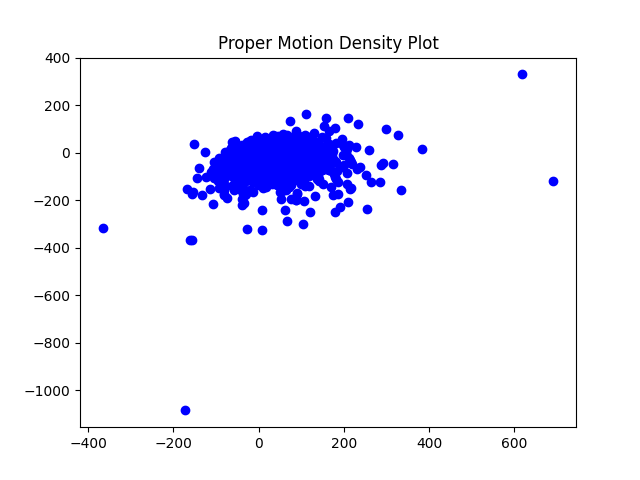


xmin:-62.62001402178464,xmax:146.23148377135226,
ymin:-110.57535621703096,ymax:36.65931957585326


In [5]:
from matplotlib.widgets import EllipseSelector

# Loading data 
g = pd.read_csv('Data/merged.csv', index_col=False)
pmra = g['pmra']
pmdec = g['pmdec']

# Create a scatter plot
fig, ax = plt.subplots()
ax.scatter(pmra, pmdec, c='blue')
plt.title('Proper Motion Density Plot')

# Define a function to be called when an ellipse is selected
def onselect(eclick, erelease):
    global xmin, xmax, ymin, ymax
    # Update the scatter plot with the selected region
    xmin = min(eclick.xdata, erelease.xdata)
    xmax = max(eclick.xdata, erelease.xdata)
    ymin = min(eclick.ydata, erelease.ydata)
    ymax = max(eclick.ydata, erelease.ydata)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    print(f'\nxmin:{xmin},xmax:{xmax},\nymin:{ymin},ymax:{ymax}')
    plt.draw()

# Create an EllipseSelector instance
selector = EllipseSelector(ax, onselect, interactive=True)

plt.show()

### 1.2 Implementing condition for outsiders

In [7]:
# Specify the condition to remove rows
condition = ((pmdec > ymin) & (pmdec < ymax)) & ((pmra > xmin) & (pmra < xmax))

# Apply the condition to filter rows
df = g.loc[condition]

# Save the DataFrame back to the CSV file
df.to_csv('Data/selected_NGC2264.csv', index=False)

r = pd.read_csv('Data/selected_NGC2264.csv', index_col=False)

### 1.3 Allows for more selective process to rid data of outsiders using parallax histogram

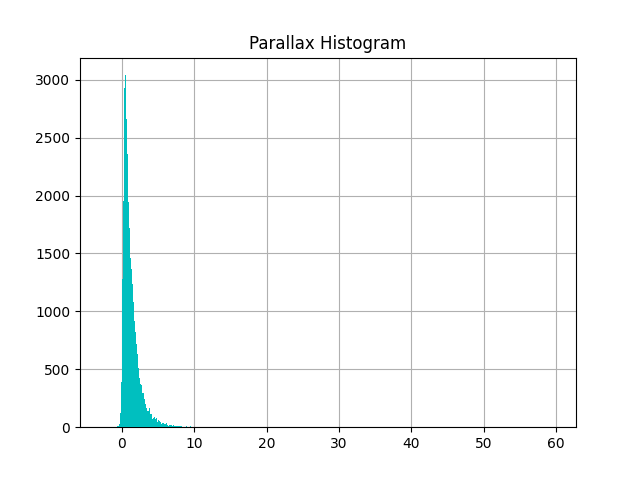

xmin: 0.04220081797522113, xmax: 1.6994809834483249


In [9]:
from matplotlib.widgets import SpanSelector

# Create a scatter plot
p = r['parallax']

fig, ax = plt.subplots()
plt.hist(p, color='c',bins='auto',zorder=3)
plt.grid(zorder=0)
plt.title('Parallax Histogram')

# Define a function to be called when a box is selected
def onselect(xmin, xmax):
    global pxmin, pxmax  # Declare the variables as global to modify them
    pxmin = xmin
    pxmax = xmax
    print(f'xmin: {pxmin}, xmax: {pxmax}')

# Create a SpanSelector
selector = SpanSelector(ax, onselect, 'horizontal', useblit=True, interactive=True)

plt.show()

### 1.4 Saving final dataset

In [10]:
# Specify conditions 
condition = ((p > pxmin) & (p < pxmax))
# Apply the condition to filter rows
df = r.loc[condition]

# Save the DataFrame back to the CSV file
df.to_csv('Data/parallax_selected_NGC2264.csv', index=False)

----------
### 2.0 Importing csv files containing cluster and known roAps
        'roAp' is the csv file including the field roAps
        'clust' is the csv file including cluster stars

In [11]:
r = pd.read_csv('Data/field_roAp_gaiaNstarhorse.csv', index_col=False)
c = pd.read_csv('Data/parallax_selected_NGC2264.csv', index_col=False)
rfeat = r.columns
cfeat = c.columns
# Dataframe of each dataset
roAp = pd.DataFrame(r)
clust = pd.DataFrame(c)
# Extracting features of all datasets
yr = (roAp['GMAG0']).values
yc = (clust['GMAG0']).values
xr = (roAp['BP-RP0']).values
xc = (clust['BP-RP0']).values

print('Total Dataset for field roAps:', roAp.shape)
print('Total Dataset for Cluster:', clust.shape)

Total Dataset for field roAps: (87, 120)
Total Dataset for Cluster: (57640, 60)


### 2.1 Transposing x and y datasets, calculating the angle between cluster and roAp positions, and calculating the resultant vector between cluster and roAp stars.

In [28]:
# For roAp dataset
xr_array = np.array([xr])
xrp_array = xr_array.transpose()

yr_array = np.array([yr])
yrp_array = yr_array.transpose()

# For cluster dataset
xc_array = np.array([xc])
yc_array = np.array([yc])
print(xc_array.shape)
# Only transposing one so that we can evenly distribute the values
xrc = (xrp_array-xc_array)
yrc = (yrp_array-yc_array)
print('Complete BP-RP shape:',xrc.shape)
print('Complete GMAG shape:',yrc.shape)
# Finding the angle using arctan(opposite/adjacent)
theta0 = np.arctan(yrc/xrc)
theta0 = np.array(theta0)
yd = yrc*(np.sin(theta0))
xd = xrc*(np.cos(theta0))
rd = (xd**2+yd**2)**(1/2) # Resultant vector for the distance between cluster and roAp stars

(1, 57640)
Complete BP-RP shape: (87, 57640)
Complete GMAG shape: (87, 57640)


### 2.2 Making roAp and cluster sigma NxM arrays so vectorization may be done

In [13]:
# Error values for roAp and cluster
gmre = np.array([(roAp['phot_g_mean_mag_error'])])
bp_rp_re = np.array([((roAp['phot_bp_mean_mag_error']))-((roAp['phot_rp_mean_mag_error']))])
gmce = np.array([(clust['phot_g_mean_mag_error'])])
bp_rp_ce = np.array([((clust['phot_bp_mean_mag_error']))-((clust['phot_rp_mean_mag_error']))])
# Squaring all terms
sq_gmre = gmre**2
sq_bp_rp_re = bp_rp_re**2
sq_gmce = gmce**2
sq_bp_rp_ce = bp_rp_ce**2
# Transposing roAp array 
gmre_p = (sq_gmre.transpose())
bp_rp_rep = (sq_bp_rp_re.transpose())
# Sigma squared terms
gme = (gmre_p+sq_gmce)
bp_rp_e = (bp_rp_rep+sq_bp_rp_ce)
# Calculating sqrt(Sigma) from all errors
sig_gme = (gme)**(1/2)
sig_bp_rp_e = (bp_rp_e)**(1/2)
print('GMAG Sigma shape:',sig_gme.shape, '\nBP-RP Sigma shape:',sig_bp_rp_e.shape)

GMAG Sigma shape: (87, 57640) 
BP-RP Sigma shape: (87, 57640)


### 2.3 Plotting the CMD to give visual of data to be analyzed

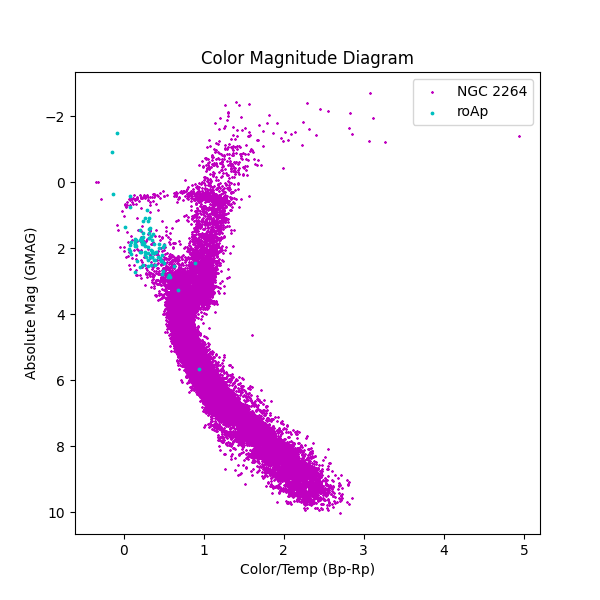

In [14]:
fig, ax = plt.subplots(1,figsize=(6,6))

plt.scatter(x=xc,y=yc,marker='*',c='m',label='NGC 2264',s=1)
plt.scatter(x=xr,y=yr,c='c',label='roAp',s=3)

plt.gca().invert_yaxis()

plt.title('Color Magnitude Diagram')
plt.ylabel('Absolute Mag (GMAG)')
plt.xlabel('Color/Temp (Bp-Rp)')
plt.legend(loc='best')
plt.savefig('Data/CMD')
plt.show()

### 2.4 Calculating resultant vector from edge of the ellipse, given the sigma and angle of each value

In [15]:
# Making the Ellipse Equation
a1 = sig_gme
b1 = sig_bp_rp_e
theta1 = np.arctan(a1/b1)
theta1 = np.array(theta1)
yD = a1*(np.sin(theta1))
xD = b1*(np.cos(theta1))
rD = (xD**2+yD**2)**(1/2) # Resultant vector for the edge of the ellipse
print('Cluster and roAp Resultant vector\n',rd,'\n-------------------------------------------------------------------------\n',
      'Error Resultant vector\n',rD)

Cluster and roAp Resultant vector
 [[0.52826521 0.72823017 1.51745173 ... 0.87182741 0.21523857 1.15916462]
 [3.35943093 3.14688961 5.41046199 ... 3.01565862 4.09501119 2.72851231]
 [2.85795128 2.65517255 4.90575118 ... 2.51508706 3.59048278 2.22562544]
 ...
 [3.32647754 3.11805785 5.37576755 ... 2.9832254  4.06060269 2.69525884]
 [2.31767974 2.1175625  4.36539402 ... 1.9747934  3.04979228 1.68461279]
 [3.70046521 3.48119818 5.75600043 ... 3.35540535 4.43934523 3.06931314]] 
-------------------------------------------------------------------------
 Error Resultant vector
 [[0.00269995 0.00381767 0.00687135 ... 0.00279134 0.00278506 0.00268093]
 [0.00267767 0.00342116 0.00660059 ... 0.00257117 0.00256553 0.00260117]
 [0.00269121 0.00342042 0.00659594 ... 0.00258075 0.00257518 0.00261405]
 ...
 [0.0026262  0.00347275 0.0066433  ... 0.00256474 0.00255871 0.00256042]
 [0.00265267 0.00341829 0.0066072  ... 0.00255078 0.00254504 0.00257666]
 [0.0026545  0.00341901 0.00660695 ... 0.0025526  0

### 2.5 Plotting single Error ellipse to show concept

<Axes.ArtistList of 1 patches>


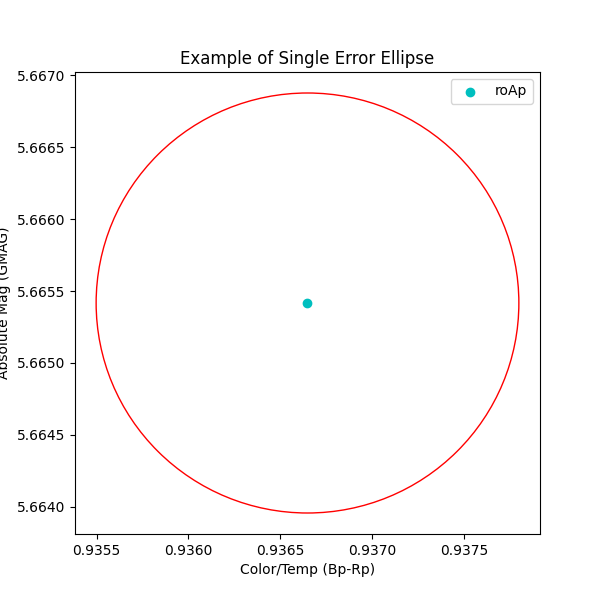

In [16]:
a0 = (a1[0][0])
b0 = (b1[0][0])
xr0 = (roAp['BP-RP0'])[0]
yr0 = (roAp['GMAG0'])[0]

fig, ax = plt.subplots(1,figsize=(6,6))

ellipse = mpatches.Ellipse(xy=(xr0,yr0),width=b0,height=a0)
ax.add_patch(ellipse)
ellipse.set_facecolor('None')
ellipse.set_edgecolor('r')
print(ax.patches)

plt.scatter(xr0,yr0,c='c',label='roAp')
plt.ylabel('Absolute Mag (GMAG)')
plt.xlabel('Color/Temp (Bp-Rp)')
plt.title('Example of Single Error Ellipse')
plt.legend(loc='best')
plt.show()

----------
### 3.0 Finding candidates using Resultant vectors and saving candidates in csv and txt files

In [17]:
gmcet = gmce.transpose()
bp_rp_cet = bp_rp_ce.transpose()
# R squared values for Cluster and roAp mag error
cands = []
n = 2 # User change the number of sigmas
# Calculating the averages
avgx = np.mean(xr)
avgy = np.mean(yr)
# Doing vectorization to classify candidates
for q in range(len(xc)):
    for i in range(len(xr)):
        if (n*abs(rD[i][q])) >= (abs(rd[i][q])):
            cands.append({'Designation':(clust['SOURCE_ID'])[q],'GMAG':(clust['GMAG0'])[q],'GMAG_Error':(gmcet)[q],'GMAG_Sigma_Error':(n*gmcet)[q],
                        'BP-RP':(clust['BP-RP0'])[q],'BP-RP_Error':(bp_rp_cet)[q],'BP-RP_Sigma_Error':(n*bp_rp_cet)[q],'Ratio-to-Sigma':((rd)[i][q])/((rD)[i][q])})
cands = pd.DataFrame(cands)
cands.to_csv('Data/roAp_NGC2264_Candidates.txt')
cands.to_csv('Data/roAp_NGC2264_Candidates.csv')
cands.head(n=len(cands))

,Designation,GMAG,GMAG_Error,GMAG_Sigma_Error,BP-RP,BP-RP_Error,BP-RP_Sigma_Error,Ratio-to-Sigma
0,2555264992887530240,2.110123,[0.000608062882556],[0.001216125765112],0.212501,[0.00034687602383459996],[0.0006937520476691999],1.119790
1,2747804455461270912,5.643498,[0.0014277959142166],[0.0028555918284332],0.908927,[0.013797895225990299],[0.027595790451980597],1.879962
2,2748234708105542272,5.635777,[0.0016431109604674],[0.0032862219209348],0.912135,[0.014141273488254301],[0.028282546976508602],1.981181
3,2748581814477869440,5.646689,[0.0017149273375356],[0.0034298546750712],0.910412,[0.0194259080295249],[0.0388518160590498],1.242963
4,2750018188980416896,3.278466,[0.0001972805365898],[0.0003945610731796],0.678381,[0.00021452094290850003],[0.00042904188581700006],1.912835
5,2750268087357612032,3.281273,[0.0002297639496744],[0.0004595278993488],0.676712,[0.00027159904268879995],[0.0005431980853775999],1.180416
6,2750427134291076864,5.684619,[0.0014924533007006],[0.0029849066014012],0.953425,[0.011665670019112201],[0.023331340038224402],1.583319
7,2750658139107646848,5.664942,[0.0005280536849934],[0.0010561073699868],0.940868,[0.0022715329878708],[0.0045430659757416],1.371599
8,2750815777291969280,5.660946,[0.0011491251489233],[0.0022982502978466],0.947474,[0.005304268830274199],[0.010608537660548398],1.925489
9,2751227720490413184,2.453315,[0.0008280268020423],[0.0016560536040846],0.879966,[0.0086881465105623],[0.0173762930211246],1.695875


### 3.1 Plotting candiates and known roAps for visualization

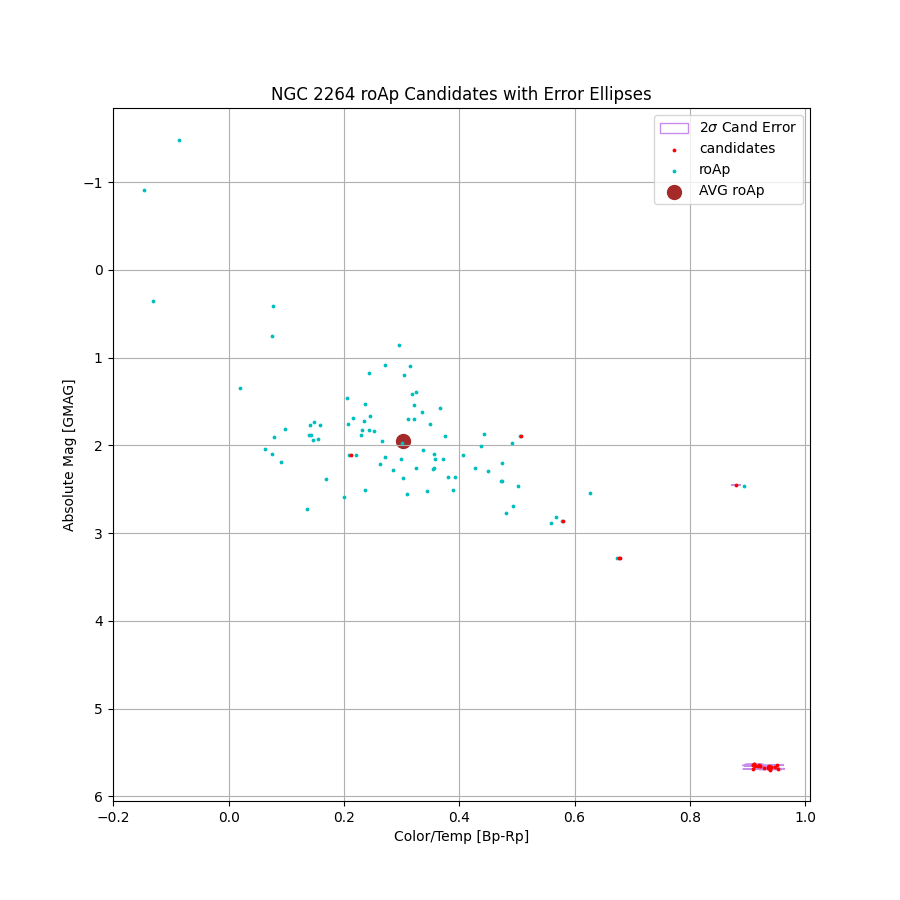

In [18]:
ub = cands['BP-RP']
ua = cands['GMAG']
xe = cands['BP-RP_Error']
ye = cands['GMAG_Error']

fig, ax = plt.subplots(1,figsize=(9,9))

ellipse0 = [mpatches.Ellipse(xy=((ub)[p],(ua)[p]),width=(n*xe)[p],height=(n*ye)[p])
           for p in range(len(ua))]
for e1 in ellipse0:
    ax.add_artist(e1)
    e1.set_facecolor(color='None')
    e1.set_edgecolor('#c88ced')
e1.set_label(f'{n}$\sigma$ Cand Error')

#plt.errorbar(ub,ua,yerr=c='red',label='Candidate',s=5,zorder=3)
plt.scatter(x=ub,y=ua,c='r',label='candidates',s=3,zorder=3)
plt.scatter(x=xr,y=yr,c='c',label='roAp',s=3,zorder=2)
plt.scatter(avgx,avgy,c='brown',s=100,label='AVG roAp',zorder=1)

plt.gca().invert_yaxis()

plt.title('NGC 2264 roAp Candidates with Error Ellipses')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.grid(zorder=1)
plt.legend(loc='best')
plt.savefig('Data/CMD with Cands')
plt.show()